# ニ値分類問題
1. titanicデータを使用 [kaggle](https://www.kaggle.com/c/titanic/data)
3. 分類器はロジスティック回帰、SVM、GBDTを試す。
   - それぞれハイパラをCVで決定し、アルゴリズムの対決をtestデータの AUCスコアで評価する

## 下準備

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
SEED = 42
np.random.seed(SEED)


In [2]:
sns.set_theme()

In [3]:
data = pd.read_csv('./dump/titanic/train.csv')
data = data.set_index('PassengerId',drop=True)

### データを眺める
#### 欠損確認

In [444]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Age、Cabin、Embarkedに欠損がある  
Pclassはカテゴリカルだが順序尺度なのでとりあえずこのまま使う？

### 分割

In [4]:
from sklearn.model_selection import train_test_split
trainval,test = train_test_split(
    data,
    test_size=.3,
    random_state=42
    )
print(f'trainval:{len(trainval)}, survived {trainval.Survived.sum()}')
print(f'test    :{len(test)}, survived {test.Survived.sum()}')

trainval:623, survived 231
test    :268, survived 111


### Pclass

In [456]:
trainval.groupby('Pclass').sum()['Survived']/trainval.groupby('Pclass').count()['Survived']

Pclass
1    0.597122
2    0.477273
3    0.241477
Name: Survived, dtype: float64

人数的にも対応的にも等間隔はちょっとビミョいのでダミー変数にする

#### SibSpとParchについて

In [457]:
print('SibSp',set(trainval.SibSp))
print('Parch',set(trainval.Parch))

SibSp {0, 1, 2, 3, 4, 5, 8}
Parch {0, 1, 2, 3, 4, 5, 6}


SibSp=8, Parch=2の一家は7人しか名前がなかったり、Parch=6の人は1人しかいないのはtrain_test_splitのため  

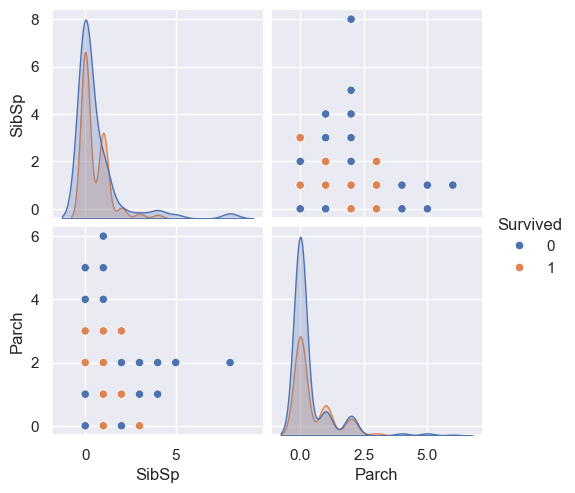

In [458]:
sns.pairplot(
    trainval[['Survived','SibSp','Parch']],
    hue='Survived'
)

In [459]:
trainval[['Survived','SibSp','Parch']].corr()

,Survived,SibSp,Parch
Survived,1.000000,-0.049527,0.076756
SibSp,-0.049527,1.000000,0.440442
Parch,0.076756,0.440442,1.000000


In [461]:
test=trainval[['Survived','SibSp','Parch']].copy()

def trans(x):
    if x==0:
        return x
    else:
        return 1

test['SibSp']=test.SibSp.apply(trans)
test['Parch']=test.Parch.apply(trans)
test.corr()


,Survived,SibSp,Parch
Survived,1.000000,0.091863,0.151970
SibSp,0.091863,1.000000,0.445302
Parch,0.151970,0.445302,1.000000


In [464]:
cross1 = pd.crosstab(trainval.SibSp,trainval.Survived)
cross1['suv_rate'] = cross1[1]/cross1.sum(axis=1)
cross1

Survived,0,1,suv_rate
SibSp,,,
0,276,142,0.339713
1,74,73,0.496599
2,12,9,0.428571
3,7,4,0.363636
4,11,3,0.214286
5,5,0,0.000000
8,7,0,0.000000


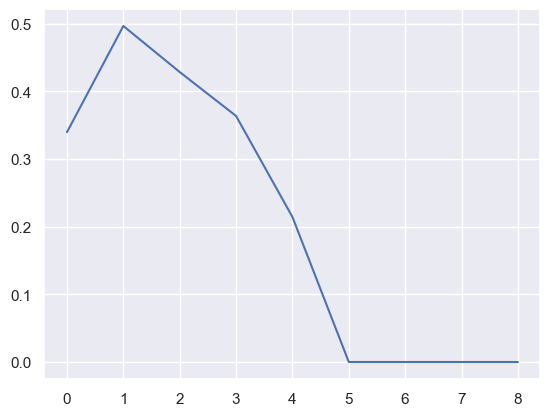

In [465]:
plt.plot(
    cross1.index,
    cross1.suv_rate,
)

In [466]:
cross1 = pd.crosstab(test.SibSp,test.Survived)
cross1['suv_rate'] = cross1[1]/cross1.sum(axis=1)
cross1

Survived,0,1,suv_rate
SibSp,,,
0,276,142,0.339713
1,116,89,0.434146


In [467]:
cross2 = pd.crosstab(trainval.Parch,trainval.Survived)
cross2['suv_rate'] = cross2[1]/cross2.sum(axis=1)
cross2

Survived,0,1,suv_rate
Parch,,,
0,316,155,0.329087
1,38,47,0.552941
2,31,26,0.456140
3,0,3,1.000000
4,3,0,0.000000
5,3,0,0.000000
6,1,0,0.000000


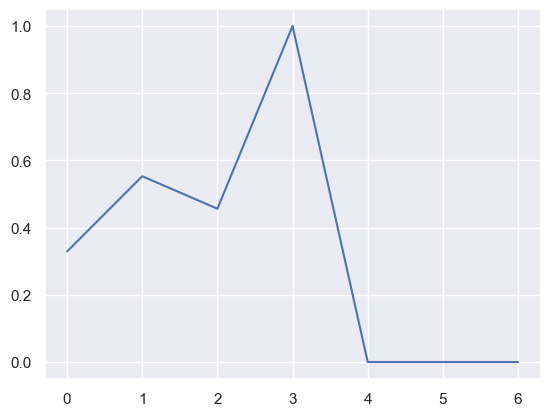

In [468]:
plt.plot(
    cross2.index,
    cross2.suv_rate,
)

In [469]:
cross2 = pd.crosstab(test.Parch,test.Survived)
cross2['suv_rate'] = cross2[1]/cross2.sum(axis=1)
cross2

Survived,0,1,suv_rate
Parch,,,
0,316,155,0.329087
1,76,76,0.500000


兄弟・家族は多すぎても良くない、とも解釈できるし、
いないよりはいた方が生存率は上がりそう（救助の優先度が上がる？）  
2値にするのはちょっとやり過ぎ感？そのまま使う

年齢は生存に関わると考えられるため、欠損値補完をして使用する。  
ある程度層化して平均を取りたい。  
分布を確認  

<Axes: xlabel='Pclass', ylabel='Age'>

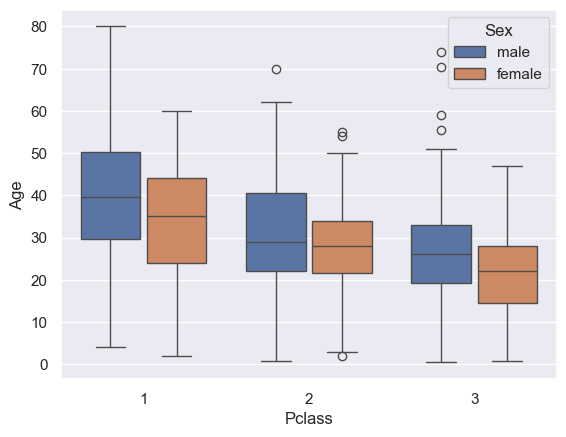

In [470]:
sns.boxplot(
    data=trainval,
    x='Pclass',
    y='Age',
    hue='Sex',
    gap=.1,
)

PclassとSexごとの平均値を使って補完する

#### Fareについて

<Axes: xlabel='Pclass', ylabel='Fare'>

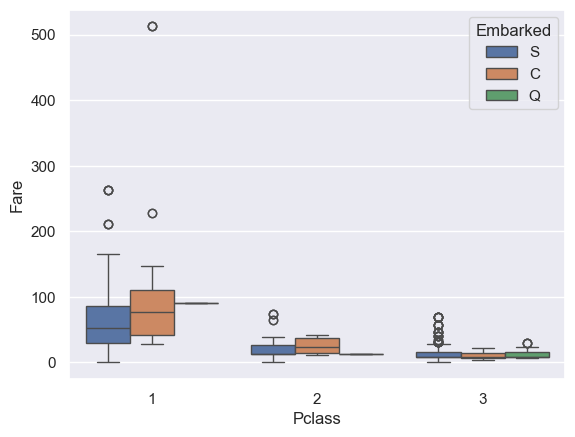

In [471]:
sns.boxplot(
    data=trainval,
    y='Fare',
    x='Pclass',
    hue='Embarked',
)

<Axes: xlabel='Pclass', ylabel='Fare'>

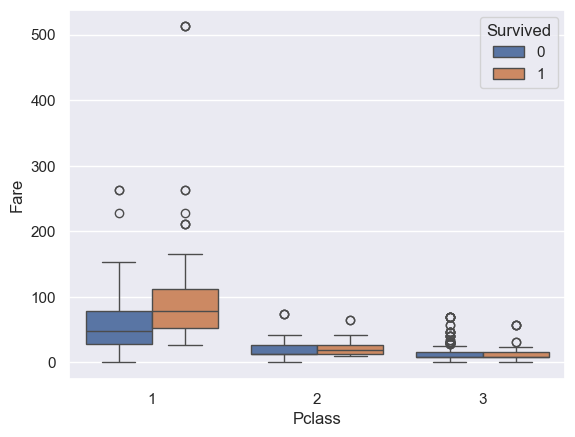

In [472]:
sns.boxplot(
    data=trainval,
    y='Fare',
    x='Pclass',
    hue='Survived',
)

pclass=1の中でも序列があって、fareはそれを表すっぽいかも。採用する

#### Embarked

In [473]:
trainval[['Survived','Embarked']].groupby('Embarked').sum() / trainval[['Survived','Embarked']].groupby('Embarked').count()

,Survived
Embarked,
C,0.563636
Q,0.381818
S,0.321663


In [474]:
trainval.groupby(['Embarked']).count()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
Embarked,,,,,,,,,,
C,110,110,110,110,86,110,110,110,110,42
Q,55,55,55,55,20,55,55,55,55,3
S,457,457,457,457,392,457,457,457,457,93


訓練データ内だとCから乗った人の生存率が高く出ているが、なんか擬似相関っぽい  
とはいえ、明確に相関がある他の特徴量がなく、異なる特徴（例えば土地柄、とか？）を表す可能性は捨てきれないので、カテゴリカルとして使用する。

### ここまでのまとめ

特徴量

- Pclass ダミー変数化
- Sex ダミー変数化
- Age PclassとSexで層化平均補正
- SibSp
- Parch
- Fare
- Embarked ダミー変数化

In [5]:
trainval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 623 entries, 446 to 103
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  623 non-null    int64  
 1   Pclass    623 non-null    int64  
 2   Name      623 non-null    object 
 3   Sex       623 non-null    object 
 4   Age       499 non-null    float64
 5   SibSp     623 non-null    int64  
 6   Parch     623 non-null    int64  
 7   Ticket    623 non-null    object 
 8   Fare      623 non-null    float64
 9   Cabin     139 non-null    object 
 10  Embarked  622 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 58.4+ KB


In [6]:
cols = [
    'Survived',
    'Pclass',
    # 'Name',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    # 'Ticket',
    'Fare',
    # 'Cabin',
    'Embarked'
]
trainval = trainval[cols]
trainval['Pclass']=trainval.Pclass.astype(str)

In [32]:
def fill_null(target,source):
    # 年齢補完
    avg_age = source.groupby(['Pclass','Sex']).Age.mean()
    target = pd.merge(
        left=target,
        right=avg_age.reset_index().rename(columns={'Age':'Avg_age'}),
        on=['Pclass','Sex'],
        how='left'
    )
    target['Age'] = target.Age.fillna(target.Avg_age)
    # Embarkedは最頻値で補完
    target['Embarked']=target.Embarked.fillna(source.Embarked.mode()[0])
    return target.drop('Avg_age',axis=1)

In [8]:
# 本来は避けるべきだが、評価のためだけなので、trainvalデータ全体で欠損値補完をしてしまう。
trainval_fillna = fill_null(trainval,trainval)
trainval_fillna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  623 non-null    int64  
 1   Pclass    623 non-null    object 
 2   Sex       623 non-null    object 
 3   Age       623 non-null    float64
 4   SibSp     623 non-null    int64  
 5   Parch     623 non-null    int64  
 6   Fare      623 non-null    float64
 7   Embarked  623 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 39.1+ KB


In [9]:
trainval_dummy = pd.get_dummies(trainval_fillna,drop_first=True).astype(float)
trainval_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623 entries, 0 to 622
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    623 non-null    float64
 1   Age         623 non-null    float64
 2   SibSp       623 non-null    float64
 3   Parch       623 non-null    float64
 4   Fare        623 non-null    float64
 5   Pclass_2    623 non-null    float64
 6   Pclass_3    623 non-null    float64
 7   Sex_male    623 non-null    float64
 8   Embarked_Q  623 non-null    float64
 9   Embarked_S  623 non-null    float64
dtypes: float64(10)
memory usage: 48.8 KB


In [10]:
feature_names = trainval_dummy.columns[1:]

### モデリング

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

In [12]:
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('poly',PolynomialFeatures()),
    ('logreg',LogisticRegression(max_iter=2000)),
])
param_grid = [
    {
        'poly__degree':[1,2],
        'logreg__penalty':['l1'],
        'logreg__solver':['liblinear'],
        'logreg__C':[0.001,0.01,0.1,1,10,100],
    },
    {
        'poly__degree':[1,2],
        'logreg__penalty':['l2'],
        'logreg__solver':['lbfgs'],
        'logreg__C':[0.001,0.01,0.1,1,10,100],
    },
]
grid = GridSearchCV(pipe,param_grid,scoring='roc_auc',cv=5)
grid.fit(trainval_dummy[feature_names],trainval_dummy['Survived'])

print(f'Best cross validation auc {grid.best_score_:.3f}')
print(f'Best Params {grid.best_params_}')

Best cross validation auc 0.849
Best Params {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear', 'poly__degree': 2}


In [13]:
pd.DataFrame(grid.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.002848,0.002169,0.001731,0.002103,0.001633,0.002555,0.001775,0.011455,0.001752,0.077756,...,0.002844,0.053377,0.003534,0.008926,0.004031,0.020054,0.00334,0.023394,0.003309,0.038949
std_fit_time,0.001271,0.000214,0.000191,0.000133,0.000035,0.000058,0.00005,0.002266,0.000051,0.041327,...,0.001621,0.038957,0.001424,0.003648,0.001643,0.002029,0.001536,0.004584,0.001632,0.024016
mean_score_time,0.001533,0.001294,0.001094,0.001119,0.001008,0.001103,0.000996,0.00104,0.000979,0.001321,...,0.002107,0.006991,0.003277,0.002395,0.001564,0.002104,0.001822,0.001641,0.001687,0.001317
std_score_time,0.000247,0.000059,0.000033,0.000056,0.000033,0.000127,0.000024,0.000026,0.000043,0.000064,...,0.001543,0.011386,0.002434,0.00106,0.00077,0.000802,0.000818,0.000793,0.000685,0.000083
param_logreg__C,0.001,0.001,0.01,0.01,0.1,0.1,1,1,10,10,...,0.01,0.01,0.1,0.1,1,1,10,10,100,100
param_logreg__penalty,l1,l1,l1,l1,l1,l1,l1,l1,l1,l1,...,l2,l2,l2,l2,l2,l2,l2,l2,l2,l2
param_logreg__solver,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,liblinear,...,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs,lbfgs
param_poly__degree,1,2,1,2,1,2,1,2,1,2,...,1,2,1,2,1,2,1,2,1,2
params,"{'logreg__C': 0.001, 'logreg__penalty': 'l1', ...","{'logreg__C': 0.001, 'logreg__penalty': 'l1', ...","{'logreg__C': 0.01, 'logreg__penalty': 'l1', '...","{'logreg__C': 0.01, 'logreg__penalty': 'l1', '...","{'logreg__C': 0.1, 'logreg__penalty': 'l1', 'l...","{'logreg__C': 0.1, 'logreg__penalty': 'l1', 'l...","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...","{'logreg__C': 1, 'logreg__penalty': 'l1', 'log...","{'logreg__C': 10, 'logreg__penalty': 'l1', 'lo...","{'logreg__C': 10, 'logreg__penalty': 'l1', 'lo...",...,"{'logreg__C': 0.01, 'logreg__penalty': 'l2', '...","{'logreg__C': 0.01, 'logreg__penalty': 'l2', '...","{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'l...","{'logreg__C': 0.1, 'logreg__penalty': 'l2', 'l...","{'logreg__C': 1, 'logreg__penalty': 'l2', 'log...","{'logreg__C': 1, 'logreg__penalty': 'l2', 'log...","{'logreg__C': 10, 'logreg__penalty': 'l2', 'lo...","{'logreg__C': 10, 'logreg__penalty': 'l2', 'lo...","{'logreg__C': 100, 'logreg__penalty': 'l2', 'l...","{'logreg__C': 100, 'logreg__penalty': 'l2', 'l..."
split0_test_score,0.5,0.5,0.708129,0.780551,0.783824,0.78928,0.783552,0.77455,0.782188,0.780824,...,0.784643,0.796099,0.785188,0.78928,0.78246,0.776732,0.78246,0.778642,0.78246,0.785188


In [14]:
pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('svc',SVC()),
])
param_grid = [
    {
        'svc__C':[0.001,0.01,0.1,1,10,100],
        'svc__gamma':[0.001,0.01,0.1,1,10,100],
    },
]
grid = GridSearchCV(pipe,param_grid,scoring='roc_auc',cv=5)
grid.fit(trainval_dummy[feature_names],trainval_dummy['Survived'])

print(f'Best cross validation auc {grid.best_score_:.3f}')
print(f'Best Params {grid.best_params_}')

Best cross validation auc 0.843
Best Params {'svc__C': 1, 'svc__gamma': 0.1}


In [15]:
pd.DataFrame(grid.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
mean_fit_time,0.00469,0.00401,0.004409,0.003875,0.003919,0.00396,0.003677,0.003915,0.003779,0.003731,...,0.004156,0.005197,0.006021,0.005924,0.003949,0.004806,0.008815,0.010983,0.008617,0.007739
std_fit_time,0.001172,0.000044,0.000771,0.000158,0.000275,0.000047,0.000085,0.000291,0.0001,0.000043,...,0.000275,0.000281,0.000627,0.000184,0.000127,0.000188,0.000739,0.003922,0.002145,0.000776
mean_score_time,0.002905,0.00266,0.002892,0.002932,0.002526,0.002431,0.002423,0.002614,0.002411,0.002441,...,0.001856,0.002147,0.002371,0.00258,0.0019,0.001818,0.002243,0.002421,0.002508,0.003255
std_score_time,0.000388,0.000098,0.000394,0.00072,0.000229,0.000066,0.00005,0.000181,0.000061,0.000052,...,0.000054,0.000041,0.000092,0.000064,0.000107,0.000099,0.000254,0.000092,0.00006,0.000738
param_svc__C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,...,10,10,10,10,100,100,100,100,100,100
param_svc__gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,...,0.1,1,10,100,0.001,0.01,0.1,1,10,100
params,"{'svc__C': 0.001, 'svc__gamma': 0.001}","{'svc__C': 0.001, 'svc__gamma': 0.01}","{'svc__C': 0.001, 'svc__gamma': 0.1}","{'svc__C': 0.001, 'svc__gamma': 1}","{'svc__C': 0.001, 'svc__gamma': 10}","{'svc__C': 0.001, 'svc__gamma': 100}","{'svc__C': 0.01, 'svc__gamma': 0.001}","{'svc__C': 0.01, 'svc__gamma': 0.01}","{'svc__C': 0.01, 'svc__gamma': 0.1}","{'svc__C': 0.01, 'svc__gamma': 1}",...,"{'svc__C': 10, 'svc__gamma': 0.1}","{'svc__C': 10, 'svc__gamma': 1}","{'svc__C': 10, 'svc__gamma': 10}","{'svc__C': 10, 'svc__gamma': 100}","{'svc__C': 100, 'svc__gamma': 0.001}","{'svc__C': 100, 'svc__gamma': 0.01}","{'svc__C': 100, 'svc__gamma': 0.1}","{'svc__C': 100, 'svc__gamma': 1}","{'svc__C': 100, 'svc__gamma': 10}","{'svc__C': 100, 'svc__gamma': 100}"
split0_test_score,0.781369,0.788462,0.789825,0.800191,0.787916,0.732679,0.783006,0.788189,0.788462,0.80401,...,0.801828,0.780005,0.789007,0.710993,0.771549,0.762821,0.811102,0.770731,0.762275,0.701991
split1_test_score,0.902312,0.905614,0.906439,0.883324,0.822785,0.756742,0.902587,0.905063,0.900385,0.905338,...,0.875069,0.832141,0.798844,0.709686,0.894606,0.866538,0.803797,0.79224,0.770226,0.711888
split2_test_score,0.765272,0.783434,0.769125,0.738305,0.698679,0.674739,0.765823,0.777655,0.76885,0.738855,...,0.733352,0.716015,0.71464,0.685058,0.779031,0.805173,0.721244,0.739406,0.722345,0.689185


In [17]:
trainval_label = trainval_fillna.copy()
Sex_encorder = LabelEncoder().fit(trainval_fillna.Sex.unique())
Embarked_encorder = LabelEncoder().fit(trainval_fillna.Embarked.unique())
trainval_label['Sex']=Sex_encorder.transform(trainval_label['Sex'])
trainval_label['Embarked']=Embarked_encorder.transform(trainval_label['Embarked'])
trainval_label = trainval_label.astype(float)
trainval_label.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1.0,1.0,1.0,4.000000,0.0,2.0,81.8583,2.0
1,0.0,3.0,1.0,26.645165,0.0,0.0,7.8958,2.0
2,1.0,3.0,0.0,1.000000,1.0,1.0,11.1333,2.0
3,0.0,2.0,1.0,36.000000,1.0,2.0,27.7500,2.0
4,0.0,2.0,1.0,43.000000,1.0,1.0,26.2500,2.0


In [18]:
feature_names_label = trainval_label.columns[1:]

In [19]:
rf = RandomForestClassifier(random_state=SEED)

param_grid = [
    {
        # 'n_estimators': [300],     # 用意する決定木モデルの数
        # 'max_features': ('sqrt' ,'log2' , None),  # ランダムに指定する特徴量の数
        # 'max_depth':    (10, 20, 30, 40, 50),     # 決定木のノード深さの制限値
        'criterion': ['gini', 'entropy'],
        'n_estimators': [10, 100, 300, 500, 1000, 1500, 2000],
        'max_depth': [3, 5, 7, 9, 11],
    },
]
grid = GridSearchCV(rf,param_grid,scoring='roc_auc',cv=5)
grid.fit(trainval_label[feature_names_label],trainval_label['Survived'])

print(f'Best cross validation auc {grid.best_score_:.3f}')
print(f'Best Params {grid.best_params_}')

Best cross validation auc 0.852
Best Params {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 300}


In [20]:
rf = RandomForestClassifier(random_state=SEED)

param_grid = [
    {
        # 'n_estimators': [300],     # 用意する決定木モデルの数
        # 'max_features': ('sqrt' ,'log2' , None),  # ランダムに指定する特徴量の数
        # 'max_depth':    (10, 20, 30, 40, 50),     # 決定木のノード深さの制限値
        'criterion': ['gini', 'entropy'],
        'n_estimators': [10, 100, 300, 500, 1000, 1500, 2000],
        'max_depth': [3, 5, 7, 9, 11],
    },
]
grid = GridSearchCV(rf,param_grid,scoring='roc_auc',cv=5)
grid.fit(trainval_dummy[feature_names],trainval_dummy['Survived'])

print(f'Best cross validation auc {grid.best_score_:.3f}')
print(f'Best Params {grid.best_params_}')

Best cross validation auc 0.851
Best Params {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 300}


In [33]:
test = test[cols].copy()
test['Pclass'] = test.Pclass.astype(str)
test_fillna = fill_null(test,trainval)
test_dummy = pd.get_dummies(test_fillna,drop_first=True).astype(float)

In [35]:
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    268 non-null    float64
 1   Age         268 non-null    float64
 2   SibSp       268 non-null    float64
 3   Parch       268 non-null    float64
 4   Fare        268 non-null    float64
 5   Pclass_2    268 non-null    float64
 6   Pclass_3    268 non-null    float64
 7   Sex_male    268 non-null    float64
 8   Embarked_Q  268 non-null    float64
 9   Embarked_S  268 non-null    float64
dtypes: float64(10)
memory usage: 21.1 KB


In [36]:
from sklearn.ensemble import VotingClassifier

logreg_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('poly',PolynomialFeatures(degree=2)),
    ('logreg',LogisticRegression(
        penalty = 'l1',
        C = 0.1,
        solver = 'liblinear',
        max_iter=2000,
        )),
])

svc_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('svc',SVC(C=1,gamma=0.1)),
])

lf = RandomForestClassifier(
    criterion='entropy',
    max_depth = 5,
    n_estimators = 300,
    random_state=SEED,
    )

estimators=[
    ('lr', logreg_pipe),
    ('svc', svc_pipe),
    ('randomforest', lf),
    ]
vote_clf=VotingClassifier(estimators=estimators, voting='hard')

In [37]:
X_train = trainval_dummy[feature_names]
y_train = trainval_dummy['Survived']
X_test = test_dummy[feature_names]
y_test = test_dummy['Survived']

def check(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    print(f'Accuracy on train data : {model.score(X_train,y_train):.3f}')
    print(f'Accuracy on test data : {model.score(X_test,y_test):.3f}')
    print(f'Accuracy on test data : {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.3f}')

In [40]:
print('logreg')
logreg_pipe.fit(X_train,y_train)
print(f'Accuracy on train data : {logreg_pipe.score(X_train,y_train):.3f}')
print(f'Accuracy on test data : {logreg_pipe.score(X_test,y_test):.3f}')
print(f'Accuracy on test data : {roc_auc_score(y_test, logreg_pipe.predict_proba(X_test)[:,1]):.3f}')


print('svc')
svc_pipe.fit(X_train,y_train)
print(f'Accuracy on train data : {svc_pipe.score(X_train,y_train):.3f}')
print(f'Accuracy on test data : {svc_pipe.score(X_test,y_test):.3f}')
print(f'Accuracy on test data : {roc_auc_score(y_test, svc_pipe.decision_function(X_test)):.3f}')

print('randomforest')
lf.fit(X_train,y_train)
print(f'Accuracy on train data : {lf.score(X_train,y_train):.3f}')
print(f'Accuracy on test data : {lf.score(X_test,y_test):.3f}')
print(f'Accuracy on test data : {roc_auc_score(y_test, lf.predict_proba(X_test)[:,1]):.3f}')

print('vote')
vote_clf.fit(X_train,y_train)
print(f'Accuracy on train data : {vote_clf.score(X_train,y_train):.3f}')
print(f'Accuracy on test data : {vote_clf.score(X_test,y_test):.3f}')

logreg
Accuracy on train data : 0.823
Accuracy on test data : 0.813
Accuracy on test data : 0.863
svc
Accuracy on train data : 0.844
Accuracy on test data : 0.817
Accuracy on test data : 0.856
randomforest
Accuracy on train data : 0.852
Accuracy on test data : 0.817
Accuracy on test data : 0.884
vote
Accuracy on train data : 0.846
Accuracy on test data : 0.821


In [43]:
t = pd.DataFrame(
    {
        'answer':y_test,
        'pred':vote_clf.predict(X_test),
    }
    )
t['correct']=t.answer == t.pred
t

,answer,pred,correct
0,1.0,0.0,False
1,0.0,0.0,True
2,0.0,0.0,True
3,1.0,1.0,True
4,1.0,1.0,True
...,...,...,...
263,1.0,0.0,False
264,0.0,0.0,True
265,0.0,0.0,True
266,0.0,0.0,True


In [46]:
print(
    f'acc:{t.correct.sum() / len(t):.3f}, correct{t.correct.sum()}/{len(t)}'
)


acc:0.821, correct220/268


voteを使うことにする。

In [ ]:
cols = [
    'Survived',
    'Pclass',
    # 'Name',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    # 'Ticket',
    'Fare',
    # 'Cabin',
    'Embarked'
]

In [73]:
cols_train = [
    'Survived',
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked'
]

train = pd.read_csv('./dump/titanic/train.csv').set_index('PassengerId',drop=True)
train = train[cols]
train['Pclass']=train.Pclass.astype(str)
train_fillna = fill_null(train,train)
train_dummy = pd.get_dummies(train_fillna,drop_first=True).astype(float)
feature_names = train_dummy.columns[1:]
X_train = train_dummy[feature_names]
y_train = train_dummy['Survived']

cols_test = [
    # 'Survived',
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked'
]

test = pd.read_csv('./dump/titanic/test.csv').set_index('PassengerId',drop=True)
test = test[cols_test]
test['Pclass']=test.Pclass.astype(str)
test_fillna = fill_null(test,train)
test_fillna = pd.merge(
    left=test_fillna,
    right=train_fillna[['Pclass','Sex','Fare']].groupby(['Pclass','Sex']).mean().reset_index().rename(columns={'Fare':'Avg_Fare'}),
    on=['Pclass','Sex'],
    how='left'
)
test_fillna['Fare']=test_fillna.Fare.fillna(test_fillna.Avg_Fare)
test_fillna = test_fillna.drop('Avg_Fare',axis=1)
test_dummy = pd.get_dummies(test_fillna,drop_first=True).astype(float)
X_test = test_dummy[feature_names]

In [74]:
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   SibSp       418 non-null    float64
 2   Parch       418 non-null    float64
 3   Fare        418 non-null    float64
 4   Pclass_2    418 non-null    float64
 5   Pclass_3    418 non-null    float64
 6   Sex_male    418 non-null    float64
 7   Embarked_Q  418 non-null    float64
 8   Embarked_S  418 non-null    float64
dtypes: float64(9)
memory usage: 29.5 KB


In [70]:
test_dummy

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,34.500000,0.0,0.0,7.8292,0.0,1.0,1.0,1.0,0.0
1,47.000000,1.0,0.0,7.0000,0.0,1.0,0.0,0.0,1.0
2,62.000000,0.0,0.0,9.6875,1.0,0.0,1.0,1.0,0.0
3,27.000000,0.0,0.0,8.6625,0.0,1.0,1.0,0.0,1.0
4,22.000000,1.0,1.0,12.2875,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
413,26.507589,0.0,0.0,8.0500,0.0,1.0,1.0,0.0,1.0
414,39.000000,0.0,0.0,108.9000,0.0,0.0,0.0,0.0,0.0
415,38.500000,0.0,0.0,7.2500,0.0,1.0,1.0,0.0,1.0
416,26.507589,0.0,0.0,8.0500,0.0,1.0,1.0,0.0,1.0


In [75]:
logreg_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('poly',PolynomialFeatures(degree=2)),
    ('logreg',LogisticRegression(
        penalty = 'l1',
        C = 0.1,
        solver = 'liblinear',
        max_iter=2000,
        )),
])

svc_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('svc',SVC(C=1,gamma=0.1)),
])

lf = RandomForestClassifier(
    criterion='entropy',
    max_depth = 5,
    n_estimators = 300,
    random_state=SEED,
    )

estimators=[
    ('lr', logreg_pipe),
    ('svc', svc_pipe),
    ('randomforest', lf),
    ]
vote_clf=VotingClassifier(estimators=estimators, voting='hard')

In [76]:
vote_clf.fit(X_train,y_train)
pred = vote_clf.predict(X_test)

In [78]:
test['Survived'] = pred
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,0.0
893,3,female,47.0,1,0,7.0000,S,0.0
894,2,male,62.0,0,0,9.6875,Q,0.0
895,3,male,27.0,0,0,8.6625,S,0.0
896,3,female,22.0,1,1,12.2875,S,1.0
...,...,...,...,...,...,...,...,...
1305,3,male,NaN,0,0,8.0500,S,0.0
1306,1,female,39.0,0,0,108.9000,C,1.0
1307,3,male,38.5,0,0,7.2500,S,0.0


In [79]:
submit = test['Survived'].astype(int)

In [81]:
submit.to_csv('./dump/titanic/submission.csv')

In [66]:
train_fillna[['Pclass','Sex','Fare']].groupby(['Pclass','Sex']).mean().reset_index().rename(columns={'Fare':'Avg_Fare'})


,Pclass,Sex,Avg_Fare
0,1,female,106.125798
1,1,male,67.226127
2,2,female,21.970121
3,2,male,19.741782
4,3,female,16.118810
5,3,male,12.661633


In [56]:
test_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         418 non-null    float64
 1   SibSp       418 non-null    float64
 2   Parch       418 non-null    float64
 3   Fare        417 non-null    float64
 4   Pclass_2    418 non-null    float64
 5   Pclass_3    418 non-null    float64
 6   Sex_male    418 non-null    float64
 7   Embarked_Q  418 non-null    float64
 8   Embarked_S  418 non-null    float64
dtypes: float64(9)
memory usage: 29.5 KB
